# The QUEST
Práca bola rozdelená férovo pre oboch zúčastnených
Adam Kubaliak 50%
Norbert Matuška 50%

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import shutil
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [6]:
# importing
dataset_path = 'dataset-periocular/dataset/dataset'

image_paths = []
labels = []

for image_name in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, image_name)
    if os.path.isfile(image_path):
        image_paths.append(image_path)
        if 'with-mask' in image_name:
            labels.append('with-mask')
        else:
            labels.append('without-mask')

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

bbox_df = pd.read_csv("dataset-periocular/Periocular  - bbox.csv")
landmarks_df = pd.read_csv("dataset-periocular/Periocular  - landmarks.csv")

In [7]:
print(df.head())
print(bbox_df.head())
print(landmarks_df.head())

                                          image_path         label
0  dataset-periocular/dataset/dataset\img000001-w...     with-mask
1   dataset-periocular/dataset/dataset\img000001.jpg  without-mask
2  dataset-periocular/dataset/dataset\img000002-w...     with-mask
3   dataset-periocular/dataset/dataset\img000002.jpg  without-mask
4   dataset-periocular/dataset/dataset\img000003.jpg  without-mask
     image_id  x_1  y_1  width  height
0  000001.jpg   95   71    226     313
1  000002.jpg   72   94    221     306
2  000003.jpg  216   59     91     126
3  000004.jpg  622  257    564     781
4  000005.jpg  236  109    120     166
     image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  \
0  000001.jpg         69        109         106         113      77     142   
1  000002.jpg         69        110         107         112      81     135   
2  000003.jpg         76        112         104         106     108     128   
3  000004.jpg         72        113         108 

## 4.1 EDA and data preprocessing
(A-4b)	EDA a data preprocessing pre Vami vybrané charakteristiky z datasetu 

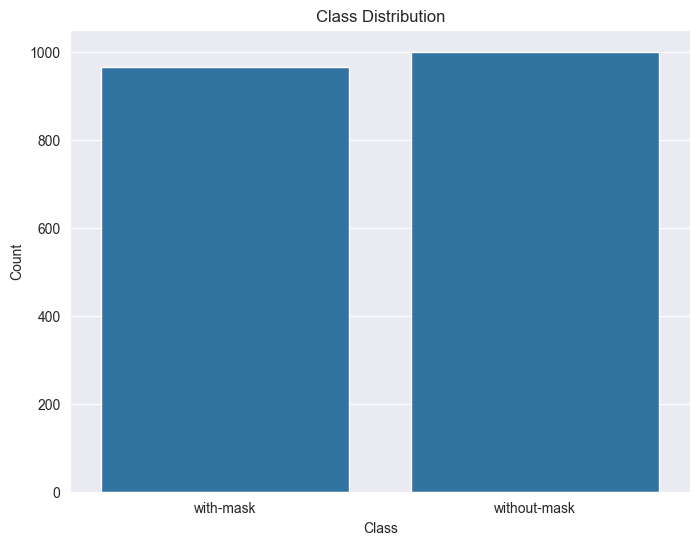

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [9]:
print("Bounding Box Data - Missing Values:")
print(bbox_df.isnull().sum())

print("\nLandmark Data - Missing Values:")
print(landmarks_df.isnull().sum())

bbox_image_ids = set(bbox_df['image_id'])
landmarks_image_ids = set(landmarks_df['image_id'])

unmatched_bbox = bbox_image_ids - landmarks_image_ids
unmatched_landmarks = landmarks_image_ids - bbox_image_ids

print(f"\nUnmatched Bounding Box IDs: {len(unmatched_bbox)}")
print(f"Unmatched Landmark IDs: {len(unmatched_landmarks)}")

Bounding Box Data - Missing Values:
image_id    0
x_1         0
y_1         0
width       0
height      0
dtype: int64

Landmark Data - Missing Values:
image_id        0
lefteye_x       0
lefteye_y       0
righteye_x      0
righteye_y      0
nose_x          0
nose_y          0
leftmouth_x     0
leftmouth_y     0
rightmouth_x    0
rightmouth_y    0
dtype: int64

Unmatched Bounding Box IDs: 0
Unmatched Landmark IDs: 0


### 1. Splitneme dáta
Pre tréning, testing a validáciu

In [10]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

Train: 1257
Validation: 315
Test: 393


### 2. Zorganizujeme si to do priečinkov

In [11]:
def organize_images(df, base_dir, dataset_type):

    target_dir = os.path.join(base_dir, dataset_type)
    
    for _, row in df.iterrows():
        label = row['label']
        image_path = row['image_path']

        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        shutil.copy(image_path, label_dir)

base_dir = "dataset" 
os.makedirs(base_dir, exist_ok=True)

organize_images(train_df, base_dir, "train")
organize_images(val_df, base_dir, "val")
organize_images(test_df, base_dir, "test")

### 3. Loadneme dataset

In [18]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(128, 128),  # Resize images
    batch_size=32
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(128, 128),
    batch_size=32
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(128, 128),
    batch_size=32
)

class_names = train_dataset.class_names

Found 1257 files belonging to 2 classes.
Found 315 files belonging to 2 classes.
Found 393 files belonging to 2 classes.


### 4. Normalizujeme pixely

In [19]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

(B-1b)	Zdôvodnite výber ML/DL metód vzhľadom na Vami vybraný dataset pre 4.2

## 4.2. Modeling and evaluation
(A-4b)	Modeluje Vami tie vybrané charakteristiky pomocou vhodných ML/DL	metód. Výsledok modelovania je najlepší model.


CNN model

In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\matus\Desktop\IAU\project\IAU_\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - accuracy: 0.7734 - loss: 0.4724 - val_accuracy: 0.9937 - val_loss: 0.0152
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 403ms/step - accuracy: 0.9906 - loss: 0.0319 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 7.1933e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 424ms/step - accuracy: 1.0000 - loss: 9.2929e-04 - val_accuracy: 1.0000 - val_loss: 5.1360e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 424ms/step - accuracy: 0.9965 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 4.7015e-05
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 417ms/step - accuracy: 0.9975 - loss: 0.0041 - val_accuracy: 0.9841 - val_loss: 0.0372
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.9714 - loss: 0.1148 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.9918 - loss: 0

In [25]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(test_loss)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 4.0022e-04
Test Accuracy: 100.00%
0.0008056748192757368


In [24]:
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.concatenate([y.numpy() for x, y in test_dataset])

misclassified = np.where(predicted_classes != true_classes)[0]

print(f"Number of misclassified samples: {len(misclassified)}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
Number of misclassified samples: 188


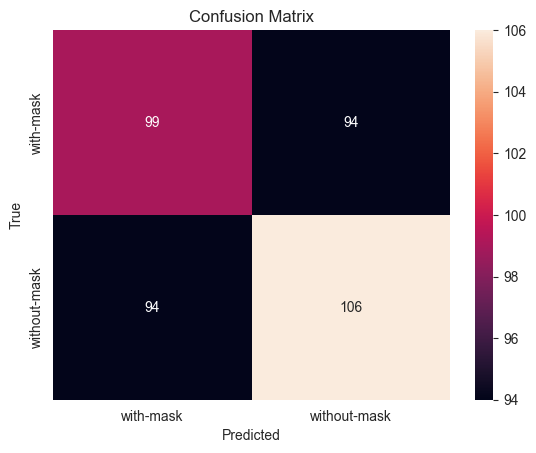

              precision    recall  f1-score   support

   with-mask       0.51      0.51      0.51       193
without-mask       0.53      0.53      0.53       200

    accuracy                           0.52       393
   macro avg       0.52      0.52      0.52       393
weighted avg       0.52      0.52      0.52       393


In [28]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_names))